<a href="https://colab.research.google.com/github/forbiddenvelocity/Kolmogorov-Arnold-Network/blob/main/Kolmogorov_Arnold_Newtwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [43]:
class OneDimSubnet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(OneDimSubnet, self).__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(self.activation(self.fc2(x)))
        x = self.dropout(self.activation(self.fc3(x)))
        x = self.fc4(x)
        return x

In [27]:
class KolmogorovArnoldNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_subnets):
        super(KolmogorovArnoldNN, self).__init__()
        self.subnets = nn.ModuleList([OneDimSubnet(1, hidden_dim) for _ in range(num_subnets)])
        self.final_layer = nn.Linear(num_subnets, output_dim)

    def forward(self, x):
        outputs = []
        for i in range(x.size(1)):
            subnet_output = self.subnets[i](x[:, i].unsqueeze(1))
            outputs.append(subnet_output)
        concatenated_outputs = torch.cat(outputs, dim=1)
        final_output = self.final_layer(concatenated_outputs)
        return final_output

In [34]:
class StandardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StandardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
def train_model(model, criterion, optimizer, x, y, num_epochs):
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return loss_history


In [50]:
input_dim = 3
hidden_dim = 5
output_dim = 1
num_epochs = 1000
learning_rate = 0.005
batch_size = 32
num_subnets = input_dim  # Number of subnets should match the input dimension

# Create dummy data
x = torch.randn((1000, input_dim))
y = torch.randn((1000, output_dim))

# Initialize models, loss function and optimizers
kann = KolmogorovArnoldNN(input_dim, hidden_dim, output_dim, num_subnets)
standard_nn = StandardNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer_kann = optim.Adam(kann.parameters(), lr=learning_rate)
optimizer_standard_nn = optim.Adam(standard_nn.parameters(), lr=learning_rate)

In [51]:
loss_kann = train_model(kann, criterion, optimizer_kann, x, y, num_epochs)
loss_standard_nn = train_model(standard_nn, criterion, optimizer_standard_nn, x, y, num_epochs)


Epoch [100/1000], Loss: 0.9678
Epoch [200/1000], Loss: 0.9643
Epoch [300/1000], Loss: 0.9614
Epoch [400/1000], Loss: 0.9571
Epoch [500/1000], Loss: 0.9567
Epoch [600/1000], Loss: 0.9584
Epoch [700/1000], Loss: 0.9584
Epoch [800/1000], Loss: 0.9522
Epoch [900/1000], Loss: 0.9534
Epoch [1000/1000], Loss: 0.9520
Epoch [100/1000], Loss: 0.9734
Epoch [200/1000], Loss: 0.9660
Epoch [300/1000], Loss: 0.9595
Epoch [400/1000], Loss: 0.9569
Epoch [500/1000], Loss: 0.9534
Epoch [600/1000], Loss: 0.9508
Epoch [700/1000], Loss: 0.9491
Epoch [800/1000], Loss: 0.9479
Epoch [900/1000], Loss: 0.9463
Epoch [1000/1000], Loss: 0.9454


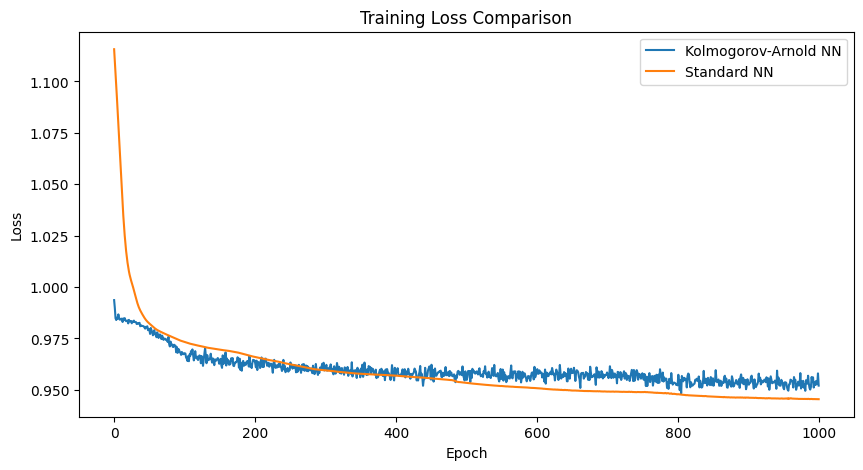

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(loss_kann, label='Kolmogorov-Arnold NN')
plt.plot(loss_standard_nn, label='Standard NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()